# Visualization & community detection

In [1]:
import networkx as nx
import math
import pandas as pd

from cdlib import viz, algorithms
from cdlib.classes import NodeClustering
from collections import defaultdict

from stock_graph_creation import get_sp500_stocks, get_sp500_stocks_info
from stock_graph_creation import correlation_to_graph, correlation_to_pos_neg_graphs
from utils import info, plot_block_model, plot_wiring_diagram

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy', 'infomap', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [2]:
stocks_info = get_sp500_stocks_info()
#correlations = get_sp500_stocks(start_date="2025-02-01", end_date="2025-03-01").corr()

YF.download() has changed argument auto_adjust default to True


[*********             18%                       ]  89 of 502 completedFailed to get ticker 'BRK.B' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  501 of 502 completed

378 Failed downloads:
['TXT', 'HUBB', 'CB', 'IPG', 'ABT', 'HPQ', 'FANG', 'KEY', 'NCLH', 'UHS', 'CINF', 'ROK', 'GRMN', 'TXN', 'OTIS', 'HAS', 'MDLZ', 'ALLE', 'VRTX', 'ZBRA', 'ADI', 'MDT', 'CTRA', 'ATO', 'LYV', 'UNH', 'TRGP', 'KHC', 'USB', 'DHI', 'DLR', 'WELL', 'ETR', 'VRSK', 'MHK', 'STZ', 'AXP', 'CRWD', 'EVRG', 'IR', 'TMUS', 'TER', 'OXY', 'MO', 'PRU', 'CAH', 'CNP', 'APTV', 'META', 'CMCSA', 'MCD', 'LLY', 'SJM', 'VMC', 'BAC', 'BKR', 'CI', 'NDSN', 'BR', 'AEP', 'AMT', 'CAG', 'COP', 'FRT', 'BAX', 'WSM', 'BEN', 'CPAY', 'PG', 'ANET', 'HCA', 'MTCH', 'JBHT', 'AMCR', 'MRK', 'MOS', 'EA', 'APD', 'SCHW', 'ISRG', 'MLM', 'ARE', 'GILD', 'INTU', 'DAY', 'TPL', 'STT', 'DUK', 'EBAY', 'NXPI', 'CPT', 'ON', 'SYK', 'EXPD', 'FOX', 'KMI', 'DVA', 'GOOG', 'RMD', 'COR', 'MKTX', 'MKC', 'CL', 'KR',

In [3]:
correlations = pd.read_csv("stonks-2025-feb.csv")
correlations = correlations.drop(columns=["Ticker"])

In [4]:
G_pos, G_neg = correlation_to_pos_neg_graphs(correlations, stocks_info, threshold=0.7)

In [5]:
info(G_pos)

       Graph | 'pos_correlations'
       Nodes | 502 (96)
       Edges | 1,313 (0)
      Degree | 5.23 (42)
         LCC | 74.7% (110)
  Clustering | 0.2374



In [6]:
def clustering(G, cluster_def):
  C = {}
  for i, data in G.nodes(data = True):
    c = data[cluster_def]
    if c not in C:
      C[c] = []
    C[c].append(i)
    
  return NodeClustering(list(C.values()), G, 'Known')

In [46]:
algs = {
    "Known": lambda G: clustering(G, cluster_def="sector"),
    #"Graph": lambda G: NodeClustering([range(len(G))],G, 'Graph'),
    #"Isolates": lambda G: NodeClustering([[i] for i in range(len(G))], G, 'Isolates'),
    "MCL": algorithms.markov_clustering,
    "EMMM": lambda G: algorithms.em(G, k = 4), #expectation maximization
    "KL": lambda G: NodeClustering([list(c) for c in nx.community.kernighan_lin_bisection(G)], G, "KL"),
    "Louvain": lambda G: algorithms.louvain(G),
    "Leiden": lambda G: algorithms.leiden(G),
    "Infomap": lambda G: algorithms.infomap(G),
    "LP": lambda G: algorithms.label_propagation(G),
    "FLP": lambda G: NodeClustering([list(c) for c in nx.community.fast_label_propagation_communities(G)], G, "Fast LP")
}

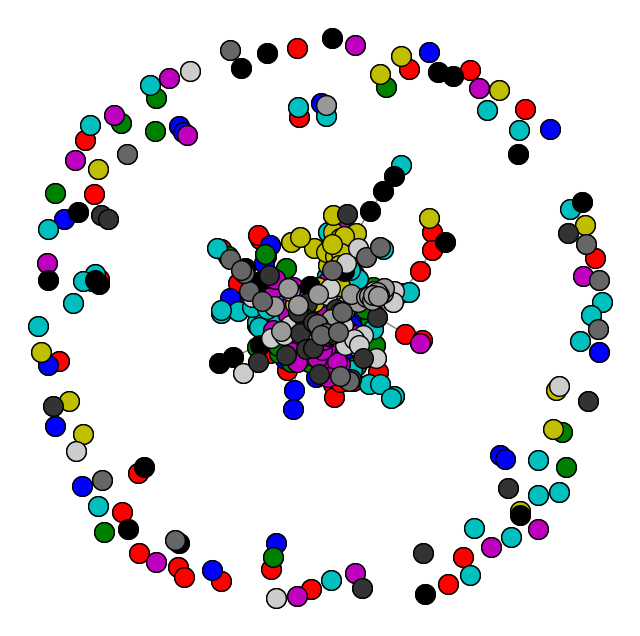

In [43]:
viz.plot_network_clusters(G_pos, algs["Known"](G_pos), nx.spring_layout(G_pos))

We can see that there are a lot of spread-out separated nodes. Lets reduce it to the largest connected component, which we know includes 74.7% of nodes.

In [8]:
def LCC(G):
    return nx.subgraph(G, max(nx.connected_components(G), key = len))

lcc = LCC(G_pos)
info(lcc)

       Graph | 'pos_correlations'
       Nodes | 375 (0)
       Edges | 1,294 (0)
      Degree | 6.90 (42)
         LCC | 100.0% (1)
  Clustering | 0.3098



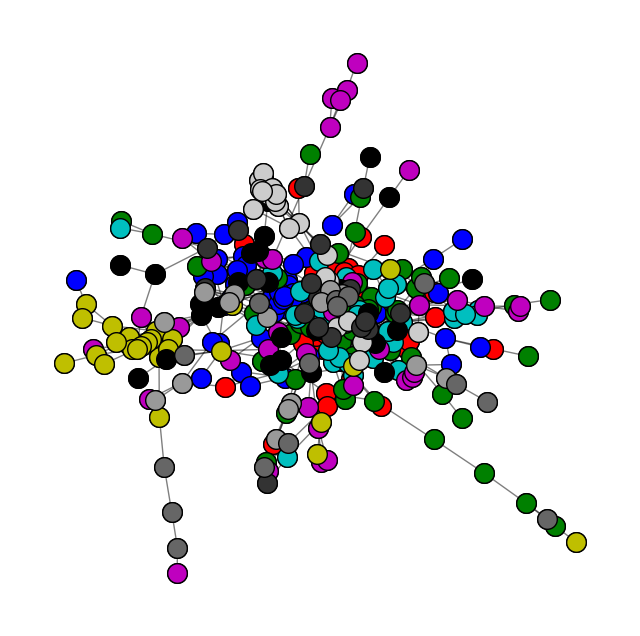

In [12]:
viz.plot_network_clusters(lcc, algs["Known"](lcc), nx.spring_layout(lcc))

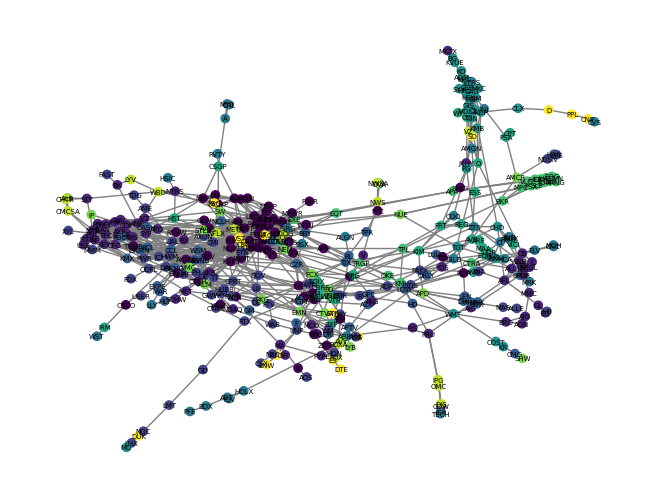

In [10]:
plot_wiring_diagram(lcc, nx.forceatlas2_layout(lcc), algs["Known"](lcc), save_file=False)

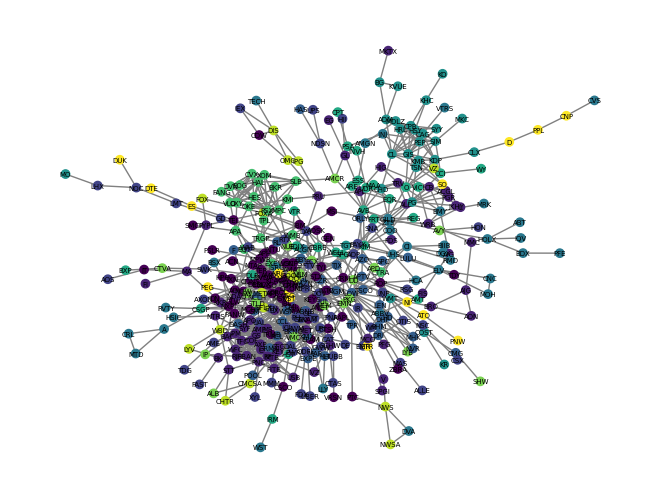

In [11]:
plot_wiring_diagram(lcc, nx.kamada_kawai_layout(lcc), algs["Known"](lcc), save_file=False)

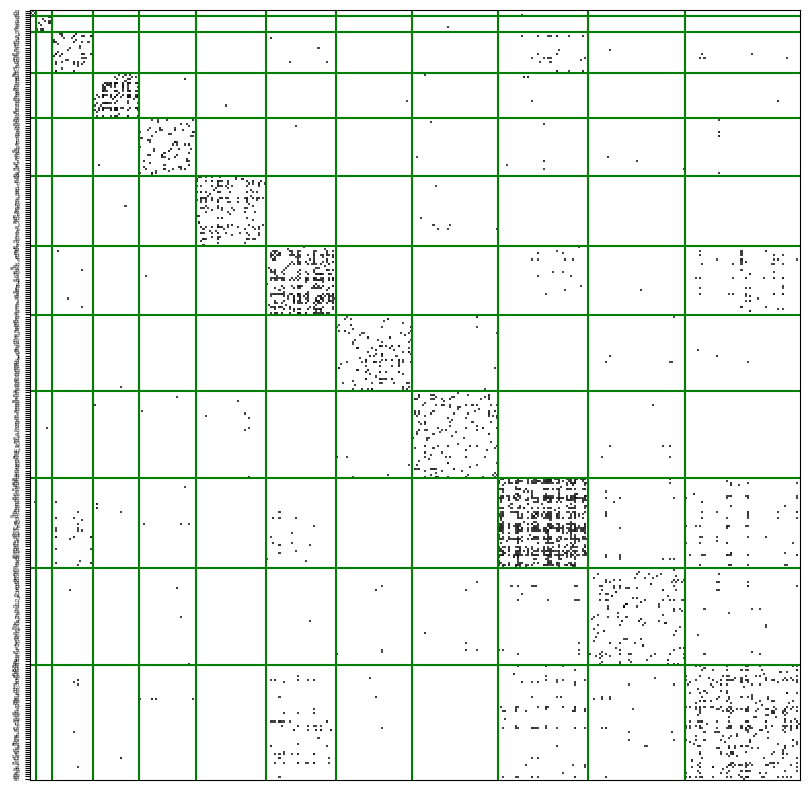

In [13]:
plot_block_model(lcc, algs["Leiden"](lcc), save_file=False)

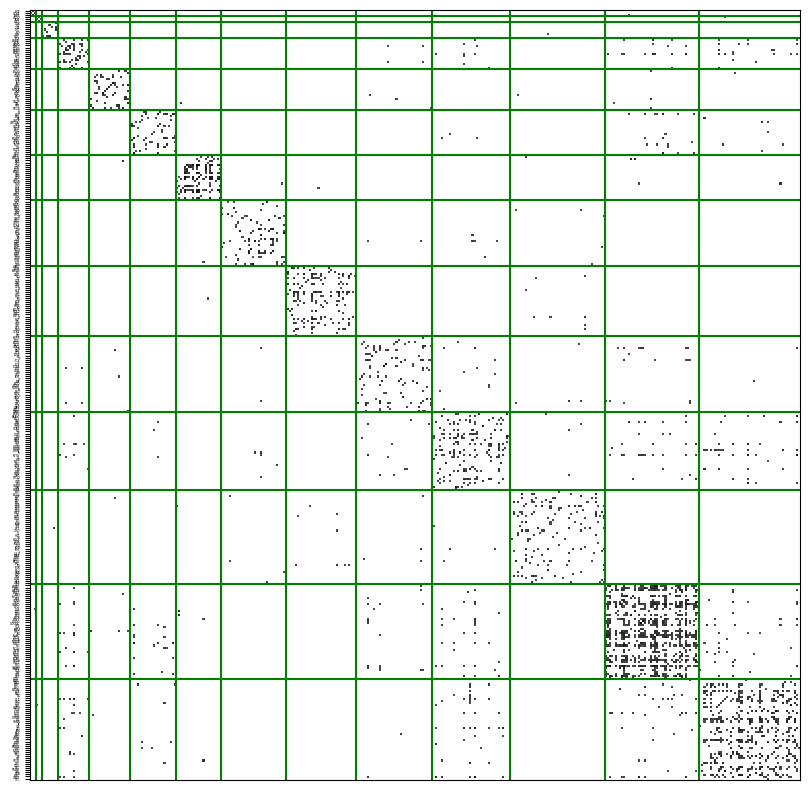

In [15]:
plot_block_model(lcc, algs["Louvain"](lcc), save_file=False)

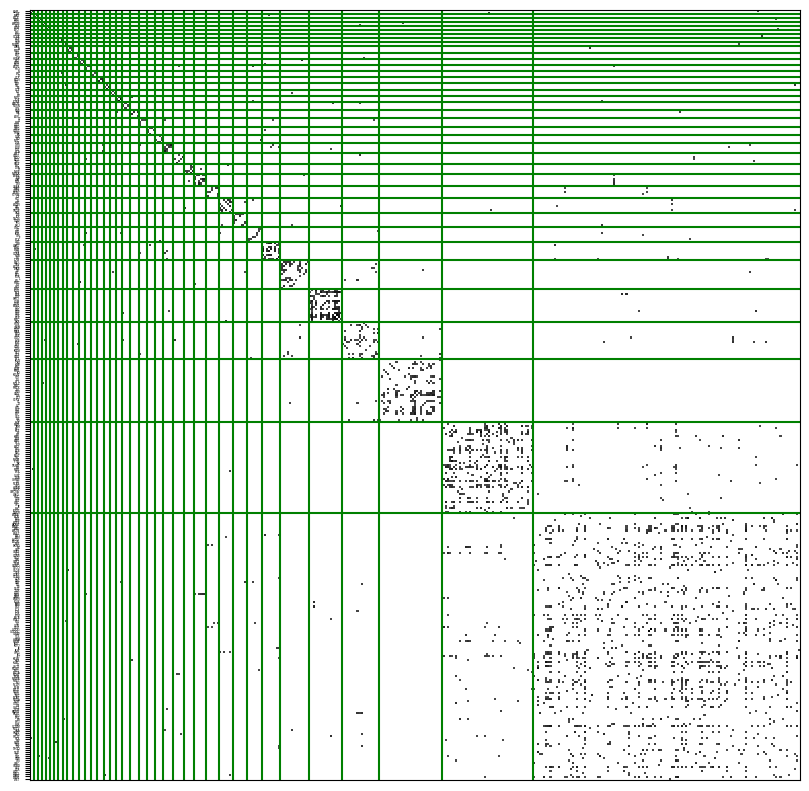

In [18]:
plot_block_model(lcc, algs["FLP"](lcc), save_file=False)

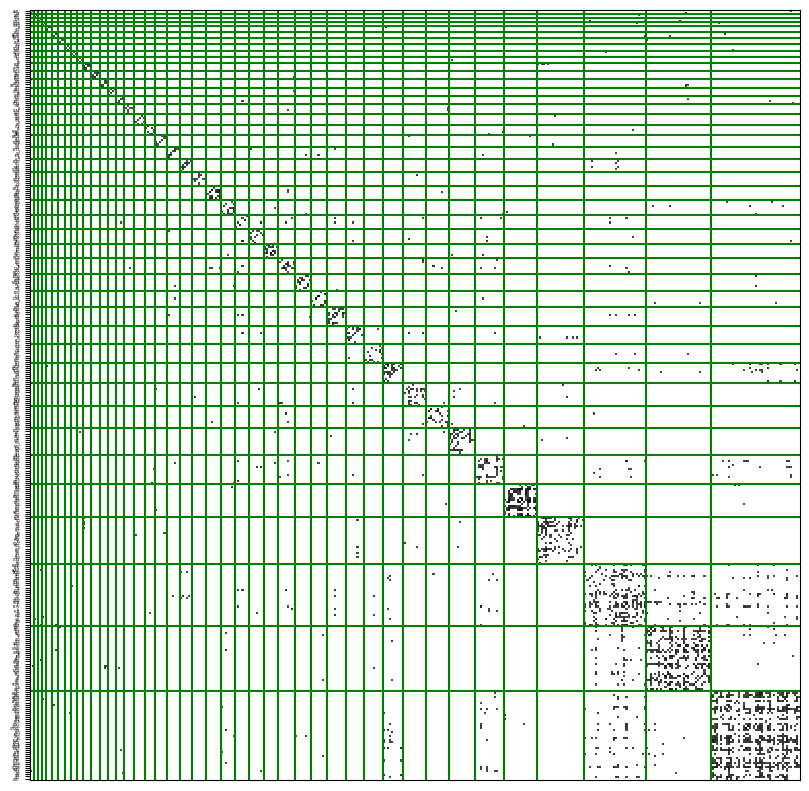

In [19]:
plot_block_model(lcc, algs["Infomap"](lcc), save_file=False)

There are visible communities. Let's compare how well the different community detection algorithms' outputs correspond to the known sectors of the stocks.

In [56]:
def comparison(G, algs, runs = 1, cluster_def='sector'):
  K = clustering(G, cluster_def)
  
  print("{:>12s} | {:>7s} {:^6s}  {:^5s}  {:^5s}  {:^5s}".format('Algorithm', 'Count', 'Q', 'NMI', 'ARI', 'NVI'))
  
  for alg in algs:
    s, Q, NMI, ARI, NVI = 0, 0, 0, 0, 0
    
    for _ in range(runs):
      C = algs[alg](G)
      s += len(C.communities) / runs
      Q += C.newman_girvan_modularity().score / runs
      NMI += K.normalized_mutual_information(C).score / runs
      ARI += K.adjusted_rand_index(C).score / runs
      NVI += K.variation_of_information(C).score / math.log(len(G)) / runs
      
    print("{:>12s} | {:>7.1f} {:6.3f}  {:5.3f}  {:5.3f}  {:5.3f}".format('\'' + alg + '\'', s, Q, NMI, ARI, NVI))
  print()

In [ ]:
def relabel_to_integers(G):
    mapping = {old_label: new_label for new_label, old_label in enumerate(G.nodes())}
    G_int = nx.relabel_nodes(G, mapping)
    return G_int

# need to make sure that graph's nodes are integers in a range [0, n), otherwise some community detection algorithms dont work...
lcc = relabel_to_integers(lcc)

In [59]:
comparison(lcc, algs)

   Algorithm |   Count   Q      NMI    ARI    NVI 
     'Known' |    11.0  0.341  1.000  1.000  0.000
       'MCL' |    84.0  0.538  0.468  0.139  0.814
      'EMMM' |     4.0  0.066  0.068  0.014  0.766
        'KL' |     2.0  0.365  0.081  0.052  0.666
   'Louvain' |    12.0  0.641  0.292  0.168  0.797
    'Leiden' |    12.0  0.644  0.307  0.174  0.788
   'Infomap' |    46.0  0.608  0.407  0.167  0.836
        'LP' |    49.0  0.430  0.401  0.129  0.738
       'FLP' |    36.0  0.543  0.391  0.166  0.727



Louvain and Leiden seem to find the most similar number of communities.

In [60]:
communities = algs["Leiden"](lcc).communities
len(communities)

12

In [63]:
for i, community in enumerate(communities):
    print(f"{i+1}. {len(community)} nodes")

1. 49 nodes
2. 49 nodes
3. 44 nodes
4. 43 nodes
5. 42 nodes
6. 37 nodes
7. 36 nodes
8. 26 nodes
9. 22 nodes
10. 16 nodes
11. 8 nodes
12. 3 nodes


Lets look inside individual communities.

In [89]:
def investigate_communities(G, communities, plot=True):
    num_nodes = []
    most_common_sector_names = []
    most_common_sector_percentages = []
    for i, community in enumerate(communities):
        subgraph = nx.induced_subgraph(G, community)
        subgraph.name = f"community {i+1}"
        info(subgraph)

        subgraph_labels = [data["label"] for _, data in subgraph.nodes(data=True)]
        print("Stocks:", ", ".join(subgraph_labels))
        print()

        sectors_counts = defaultdict(int)
        for _, data in subgraph.nodes(data=True):
            sectors_counts[data["sector"]] += 1
        sectors_counts_sorted = sorted(sectors_counts.items(), key=lambda item: item[1], reverse=True)
        for sector, count in sectors_counts_sorted:
            print(f"{sector}: {count}")
        print()

        num_nodes.append(len(community))
        most_common_sector_names.append(sectors_counts_sorted[0][0])
        ratio = sectors_counts_sorted[0][1] / len(community)
        most_common_sector_percentages.append(round(ratio * 100, 1))

        if plot:
            plot_wiring_diagram(subgraph, nx.forceatlas2_layout(subgraph), save_file=False)

    return num_nodes, most_common_sector_names, most_common_sector_percentages

       Graph | 'community 1'
       Nodes | 49 (0)
       Edges | 70 (0)
      Degree | 2.86 (8)
         LCC | 100.0% (1)
  Clustering | 0.2643

Stocks: F, FCX, FI, ADSK, FOX, FOXA, OKE, OMC, ALGN, GEN, GM, GPC, PKG, AOS, APTV, PRU, PYPL, AZO, RL, RSG, IBM, IEX, BSX, IPG, SPG, CBRE, IT, SPGI, CDW, TECH, TEL, KMI, TPL, TPR, TRGP, TYL, MA, CZR, MCO, DAY, VTR, MGM, DIS, WELL, DTE, WMB, EQIX, ES, NI

Consumer Discretionary: 9
Information Technology: 7
Financials: 6
Communication Services: 5
Energy: 5
Real Estate: 5
Industrials: 4
Health Care: 3
Utilities: 3
Materials: 2



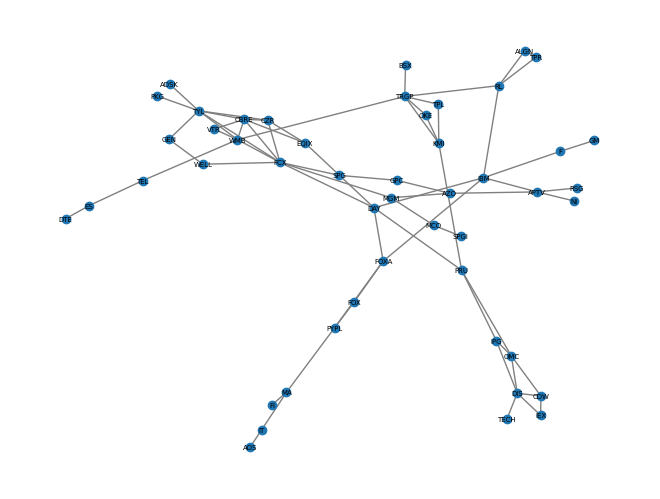

       Graph | 'community 2'
       Nodes | 49 (0)
       Edges | 140 (0)
      Degree | 5.71 (15)
         LCC | 100.0% (1)
  Clustering | 0.3670

Stocks: ABNB, FDX, ACN, FFIV, ODFL, AKAM, FTV, GE, GEV, AME, PH, GWW, PNR, HLT, HUBB, BKNG, HWM, SCHW, CAT, IRM, CCL, JCI, TDG, KEYS, CMI, CPRT, TT, LII, LLY, CSCO, UAL, UBER, CTAS, CTSH, URI, MAR, DAL, VMC, MET, VRSN, DE, WAB, MLM, DOV, WSM, WST, EPAM, NDAQ, EXPE

Industrials: 26
Information Technology: 8
Consumer Discretionary: 7
Financials: 3
Health Care: 2
Materials: 2
Real Estate: 1



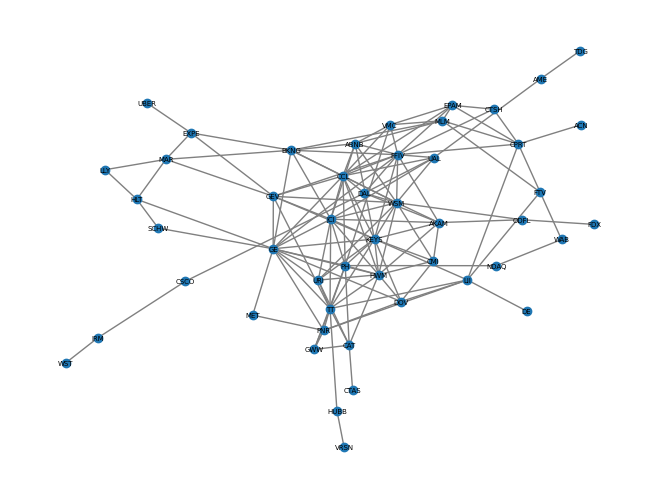

       Graph | 'community 3'
       Nodes | 44 (0)
       Edges | 323 (0)
      Degree | 14.68 (32)
         LCC | 100.0% (1)
  Clustering | 0.6784

Stocks: NTAP, NVDA, FSLR, FTNT, ORCL, AMAT, AMD, GOOG, GOOGL, AMZN, ANET, APH, AVGO, QCOM, HPE, HPQ, BBY, INTU, SNPS, ISRG, CDNS, JBL, CEG, STX, SW, TER, KLAC, CRWD, LRCX, VST, META, DELL, WDC, DLR, MPWR, MSFT, MU, NOW, EQT, NEM, NFLX, ETN, EXE, NRG

Information Technology: 28
Communication Services: 4
Utilities: 3
Consumer Discretionary: 2
Materials: 2
Energy: 2
Health Care: 1
Real Estate: 1
Industrials: 1



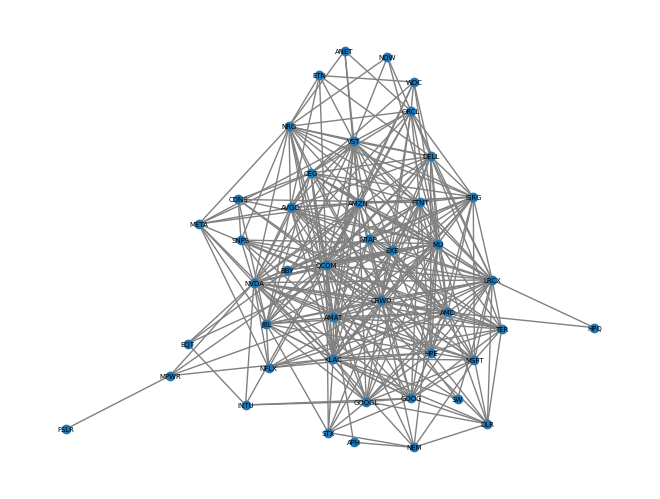

       Graph | 'community 4'
       Nodes | 43 (0)
       Edges | 174 (0)
      Degree | 8.09 (22)
         LCC | 100.0% (1)
  Clustering | 0.4958

Stocks: AAPL, FITB, ALB, PANW, GLW, AMP, GRMN, GS, PNC, POOL, APO, HBAN, PWR, AXON, AXP, RCL, BAC, RF, RJF, BX, IP, C, STLD, IVZ, STT, CFG, JPM, CHTR, KEY, SYF, CMCSA, KKR, TFC, COF, KMX, TRMB, USB, DASH, MMM, WFC, MS, MTB, XYL

Financials: 25
Consumer Discretionary: 5
Information Technology: 4
Industrials: 4
Materials: 3
Communication Services: 2



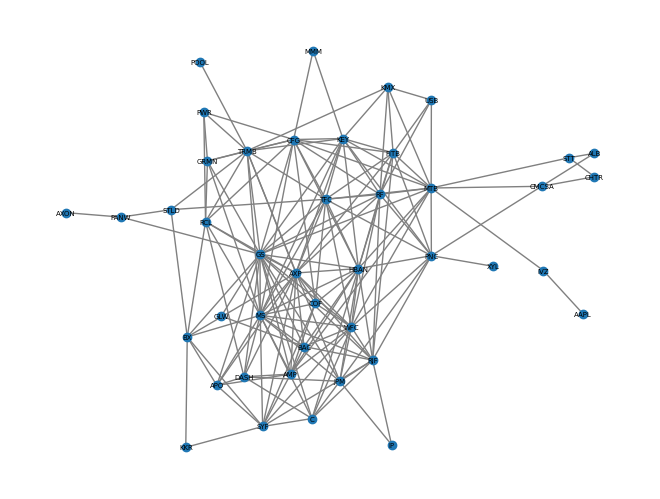

       Graph | 'community 5'
       Nodes | 42 (0)
       Edges | 71 (0)
      Degree | 3.38 (10)
         LCC | 100.0% (1)
  Clustering | 0.2728

Stocks: ABT, ACGL, FDS, AFL, FRT, ORLY, ALL, PAYX, GILD, GL, PFE, PGR, ARE, AVB, HIG, AVY, HII, HOLX, HON, REG, BDX, BMY, INVH, SNA, IQV, CB, CHD, TDY, KIM, TJX, COO, TRV, L, UDR, LULU, MAA, VICI, WRB, MRK, EG, ZTS, EQR

Financials: 12
Health Care: 10
Real Estate: 10
Industrials: 4
Consumer Discretionary: 3
Materials: 1
Consumer Staples: 1
Information Technology: 1



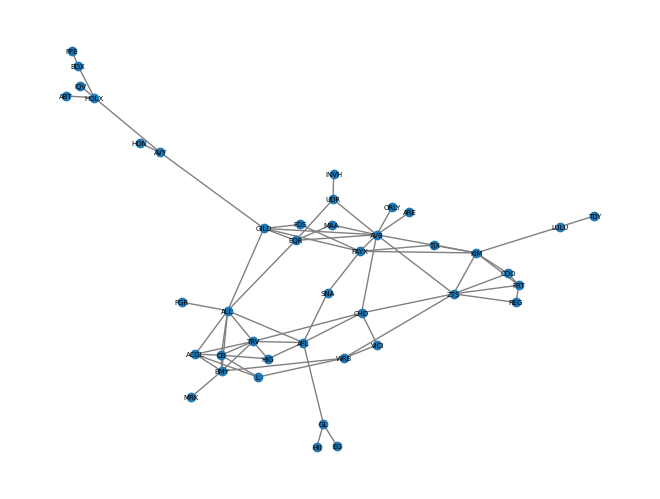

       Graph | 'community 6'
       Nodes | 37 (0)
       Edges | 56 (0)
      Degree | 3.03 (9)
         LCC | 100.0% (1)
  Clustering | 0.3244

Stocks: NVR, ADP, AJG, OTIS, ALLE, PFG, AMT, PHM, AON, APD, HCA, HD, RMD, BIIB, ROP, BRO, SHW, IR, CI, CMG, TGT, CNC, COST, KR, LEN, LOW, UHS, CTRA, MAS, MHK, DGX, DHI, MMC, MOH, WMT, ELV, EMR

Health Care: 9
Consumer Discretionary: 8
Industrials: 6
Financials: 5
Consumer Staples: 4
Materials: 2
Real Estate: 1
Information Technology: 1
Energy: 1



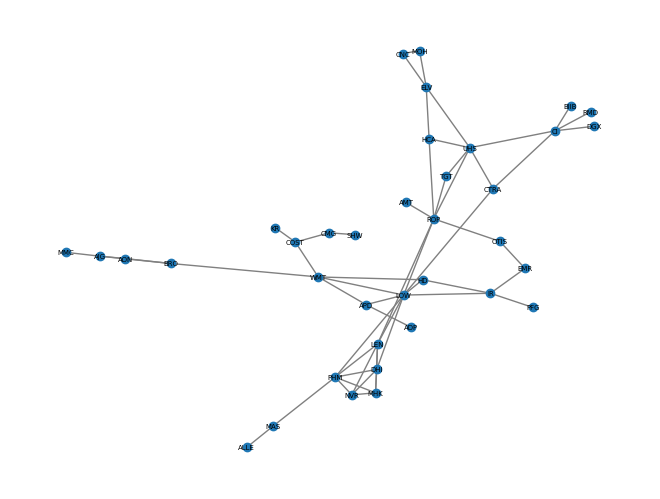

       Graph | 'community 7'
       Nodes | 36 (0)
       Edges | 79 (0)
      Degree | 4.39 (15)
         LCC | 100.0% (1)
  Clustering | 0.3039

Stocks: ADM, O, GIS, PEP, AMGN, PG, PPL, HRL, BG, HSY, SJM, CAG, SO, CCI, JKHY, JNJ, SYY, KDP, CL, CLX, KHC, KMB, CNP, KO, CPB, KVUE, TSN, CVS, D, MDLZ, VTRS, VZ, MKC, MKTX, WY, ESS

Consumer Staples: 21
Real Estate: 4
Health Care: 4
Utilities: 4
Financials: 2
Communication Services: 1



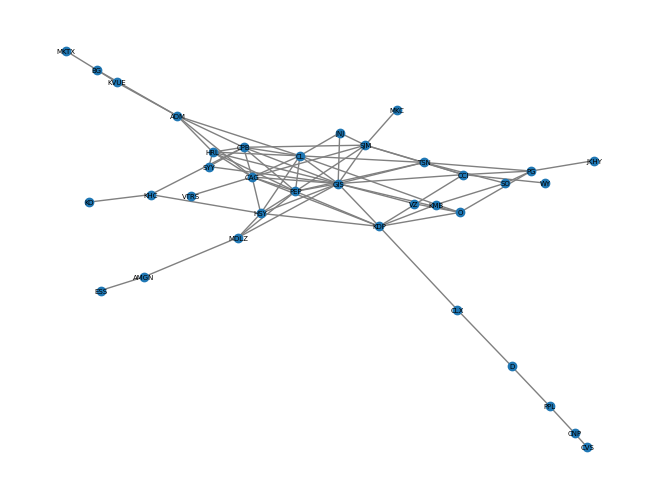

       Graph | 'community 8'
       Nodes | 26 (0)
       Edges | 33 (0)
      Degree | 2.54 (6)
         LCC | 100.0% (1)
  Clustering | 0.2128

Stocks: NSC, ABBV, NTRS, NWS, NWSA, FIS, AIG, PNW, ATO, PTC, HSIC, HST, INTC, TSCO, CRM, CSX, LYB, UNP, V, DD, DRI, WM, DVA, EMN, ZBRA, ETR

Industrials: 4
Financials: 4
Information Technology: 4
Health Care: 3
Utilities: 3
Materials: 3
Communication Services: 2
Consumer Discretionary: 2
Real Estate: 1



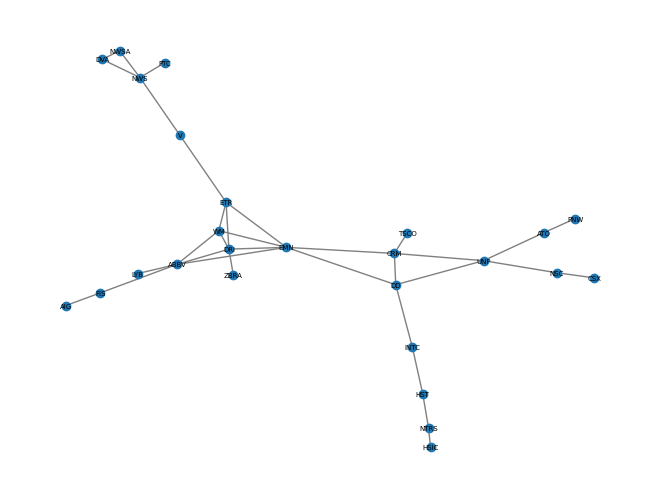

       Graph | 'community 9'
       Nodes | 22 (0)
       Edges | 63 (0)
      Degree | 5.73 (13)
         LCC | 100.0% (1)
  Clustering | 0.5099

Stocks: FANG, NUE, OXY, AMCR, APA, HAL, HAS, PSA, HES, PSX, BKR, SLB, SMCI, CPT, UPS, CVX, VLO, MPC, DVN, XOM, EOG, NDSN

Energy: 14
Materials: 2
Real Estate: 2
Industrials: 2
Consumer Discretionary: 1
Information Technology: 1



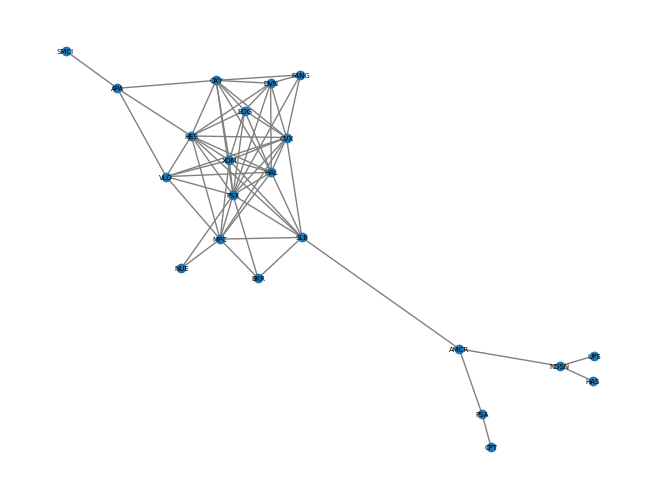

       Graph | 'community 10'
       Nodes | 16 (0)
       Edges | 24 (0)
      Degree | 3.00 (6)
         LCC | 100.0% (1)
  Clustering | 0.4062

Stocks: A, MCHP, FAST, ADI, NCLH, NXPI, WBD, ON, BK, RVTY, CRL, PEG, MTD, TXN, CSGP, LYV

Information Technology: 5
Health Care: 4
Communication Services: 2
Industrials: 1
Consumer Discretionary: 1
Financials: 1
Utilities: 1
Real Estate: 1



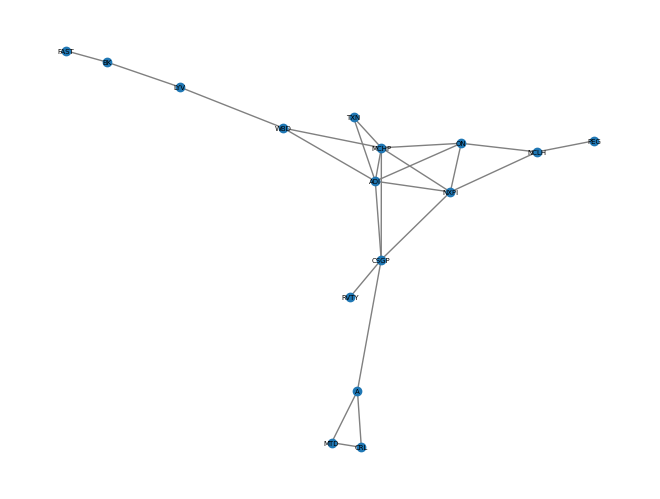

       Graph | 'community 11'
       Nodes | 8 (0)
       Edges | 7 (0)
      Degree | 1.75 (3)
         LCC | 100.0% (1)
  Clustering | 0.0000

Stocks: MO, DUK, GD, RTX, LHX, MSI, LMT, NOC

Industrials: 5
Consumer Staples: 1
Utilities: 1
Information Technology: 1



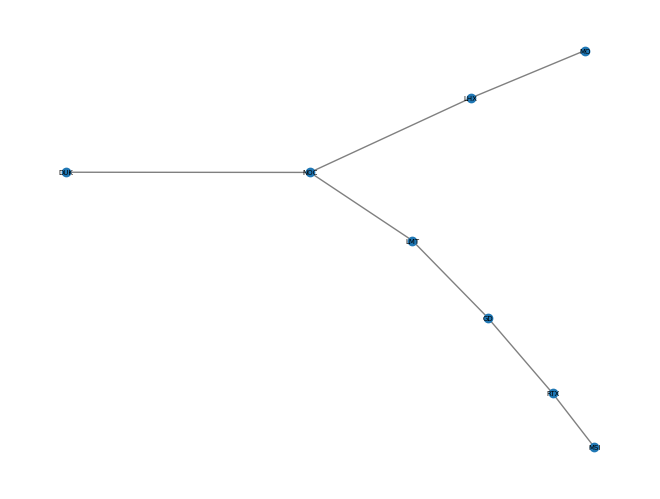

       Graph | 'community 12'
       Nodes | 3 (0)
       Edges | 2 (0)
      Degree | 1.33 (2)
         LCC | 100.0% (1)
  Clustering | 0.0000

Stocks: SWK, CTVA, BXP

Industrials: 1
Materials: 1
Real Estate: 1



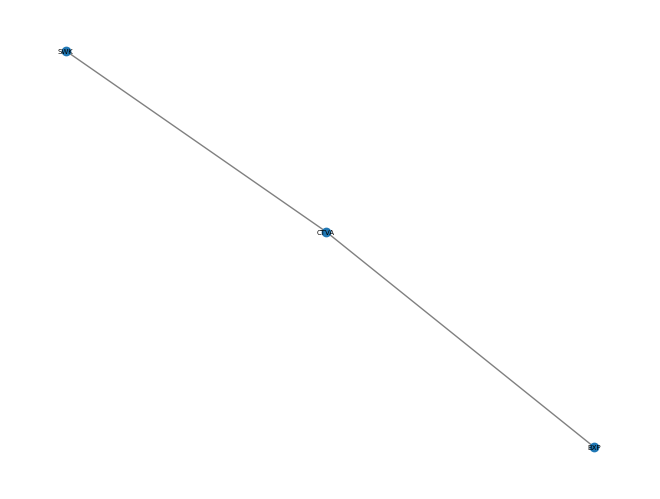

In [90]:
num_nodes, sector_names, sector_percentages = investigate_communities(lcc, communities)

In [93]:
results = pd.DataFrame({
    "Number of stocks in community": num_nodes,
    "Most common sector": sector_names,
    "% of stocks in that sector": sector_percentages
})
results.index = results.index + 1
#results.index.name = "Detected community"
results

,Number of stocks in community,Most common sector,% of stocks in that sector
1,49,Consumer Discretionary,18.4
2,49,Industrials,53.1
3,44,Information Technology,63.6
4,43,Financials,58.1
5,42,Financials,28.6
6,37,Health Care,24.3
7,36,Consumer Staples,58.3
8,26,Industrials,15.4
9,22,Energy,63.6
10,16,Information Technology,31.2


About half of the detected communities have a clear majority sector:
* community 2 - Industrials
* community 3 - Information Technology
* community 4 - Financials
* community 7 - Consumer Staples
* community 9 - Energy
* community 11 - Industrials

**TODO**: Similar analysis for different community detection algrithms